In [4]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda * y + 1) / lmbda))

Populating the interactive namespace from numpy and matplotlib


In [5]:
salaries = pd.read_csv('salaries.csv', sep=';')


def convert_to_datetime(time):
    return datetime.datetime.strptime(str(time), "%d.%m.%Y")


salaries.index = salaries.month.map(convert_to_datetime)
salaries.drop('month', axis=1)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


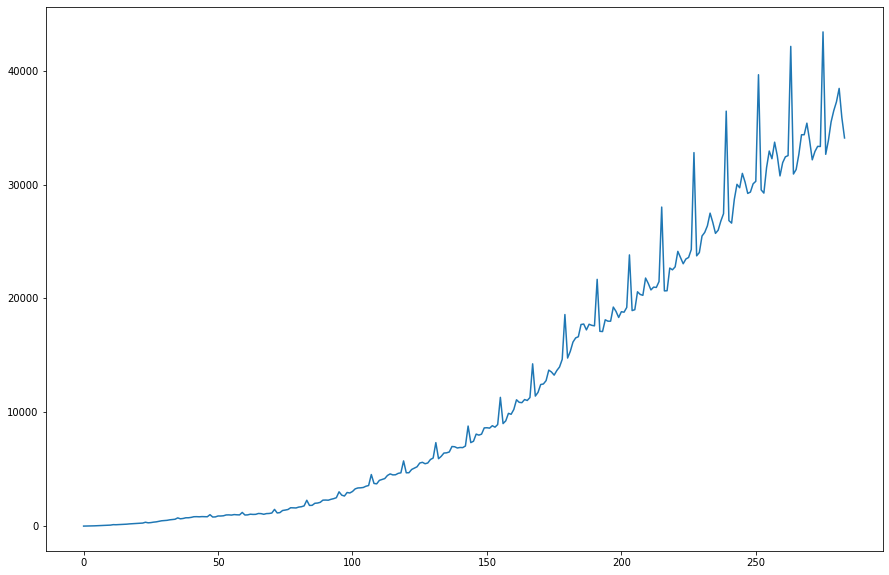

In [6]:
# Task 1
# Visualize data

pyplot.figure(figsize=(15, 10))
pyplot.plot(range(salaries.shape[0]), salaries['WAG_C_M'])

<Figure size 1080x720 with 0 Axes>

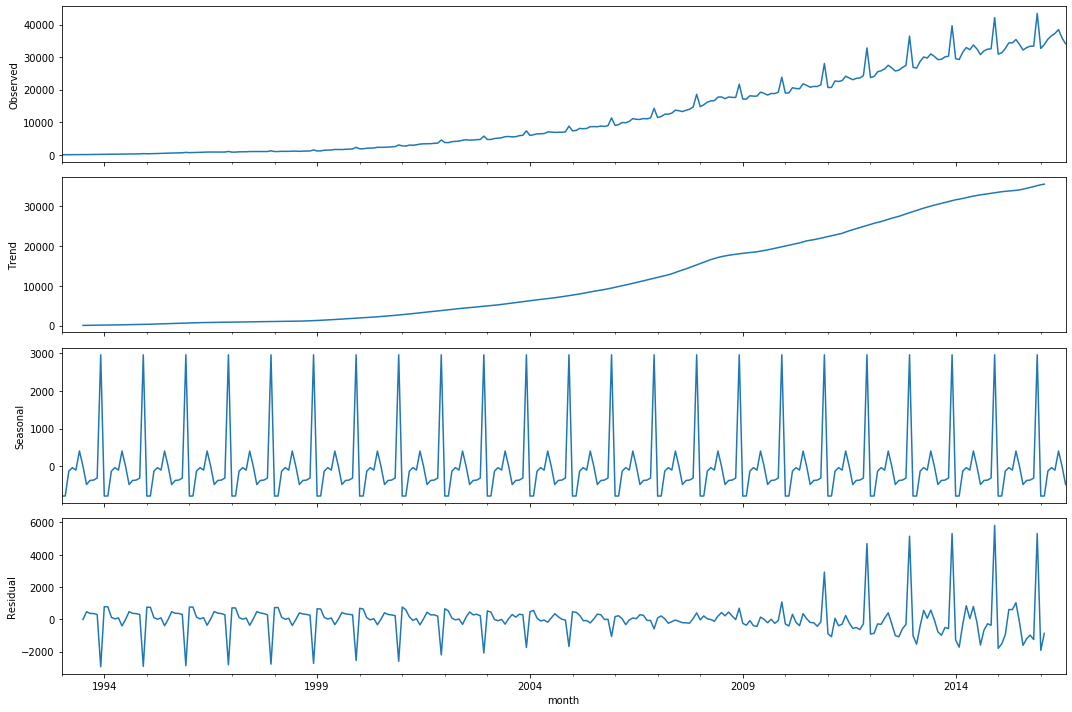

In [7]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries['WAG_C_M']).plot()
print("")

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


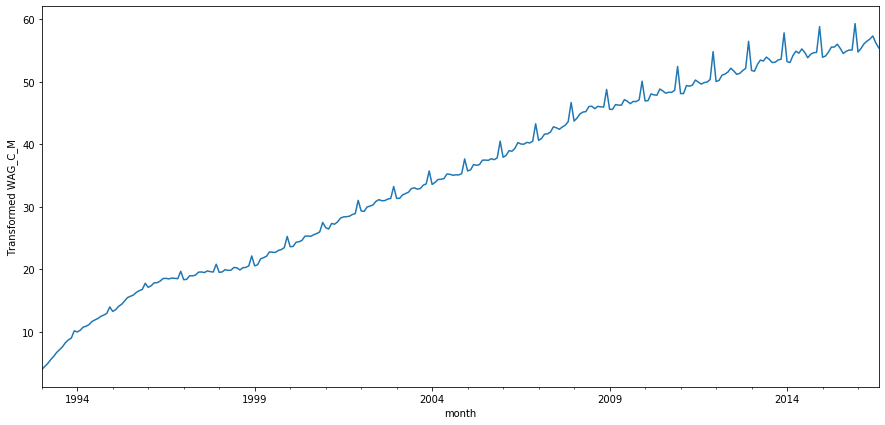

In [8]:
# Task 2
# Cтабилизация дисперции

# примерим преобрзаование Бокса-Кокса, т.к. дисперсия к концу ряда увеличивается
salaries['box_cox'], lmbda = stats.boxcox(salaries['WAG_C_M'])
plt.figure(figsize(15,7))
salaries['box_cox'].plot()
plt.ylabel(u'Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries['box_cox'])[1])

<Figure size 1080x720 with 0 Axes>

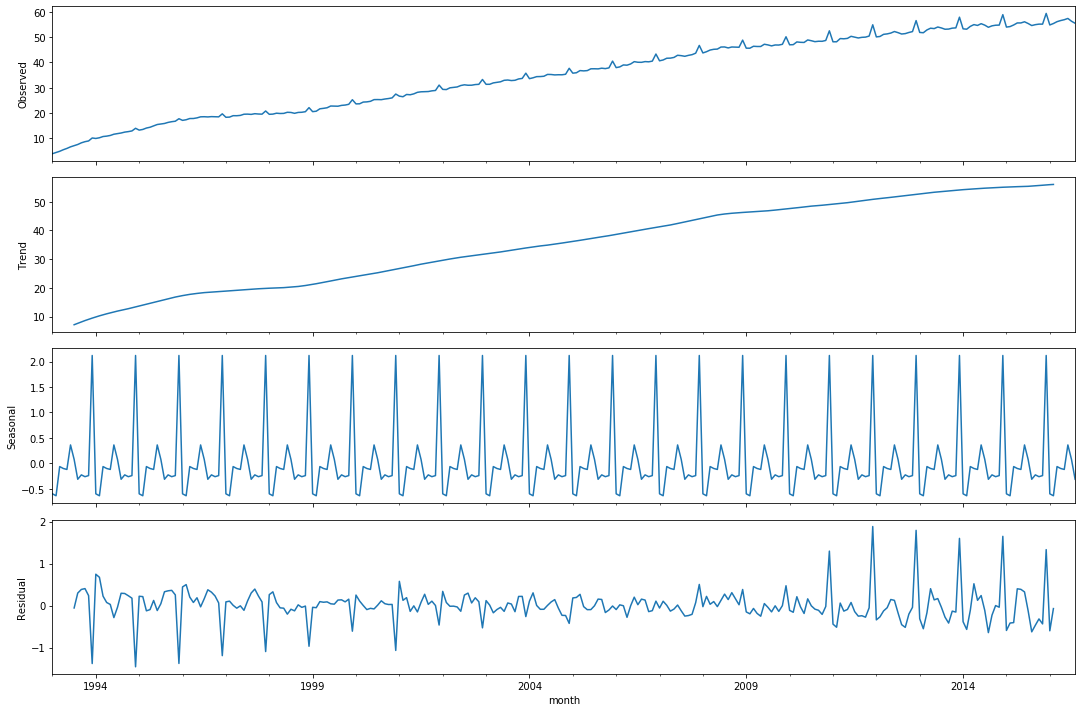

In [9]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries['box_cox']).plot()
print("")

In [10]:
# критерий не отвергается, примением сезонное дифференцирование

salaries['box_cox_diff'] = salaries['box_cox'] - salaries['box_cox'].shift(12)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries['box_cox_diff'][12:])[1])

Критерий Дики-Фуллера: p=0.014697


Text(0, 0.5, 'Дифферецированные данные')

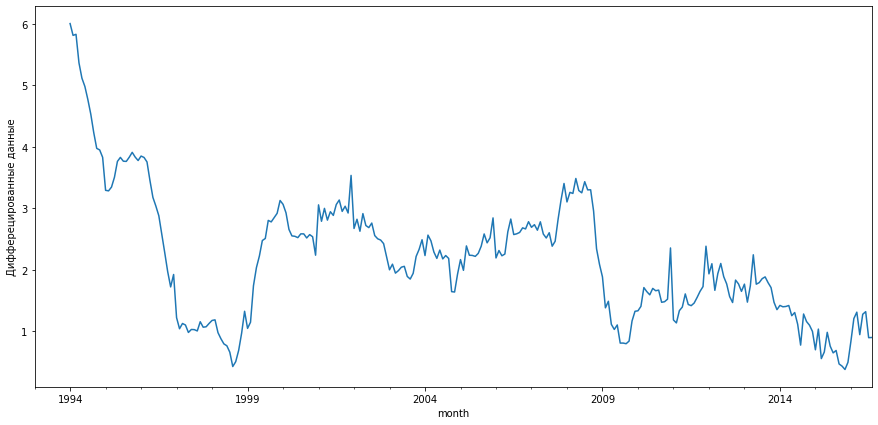

In [11]:
plt.figure(figsize(15,7))
salaries['box_cox_diff'].plot()
plt.ylabel(u'Дифферецированные данные')

<Figure size 1080x720 with 0 Axes>

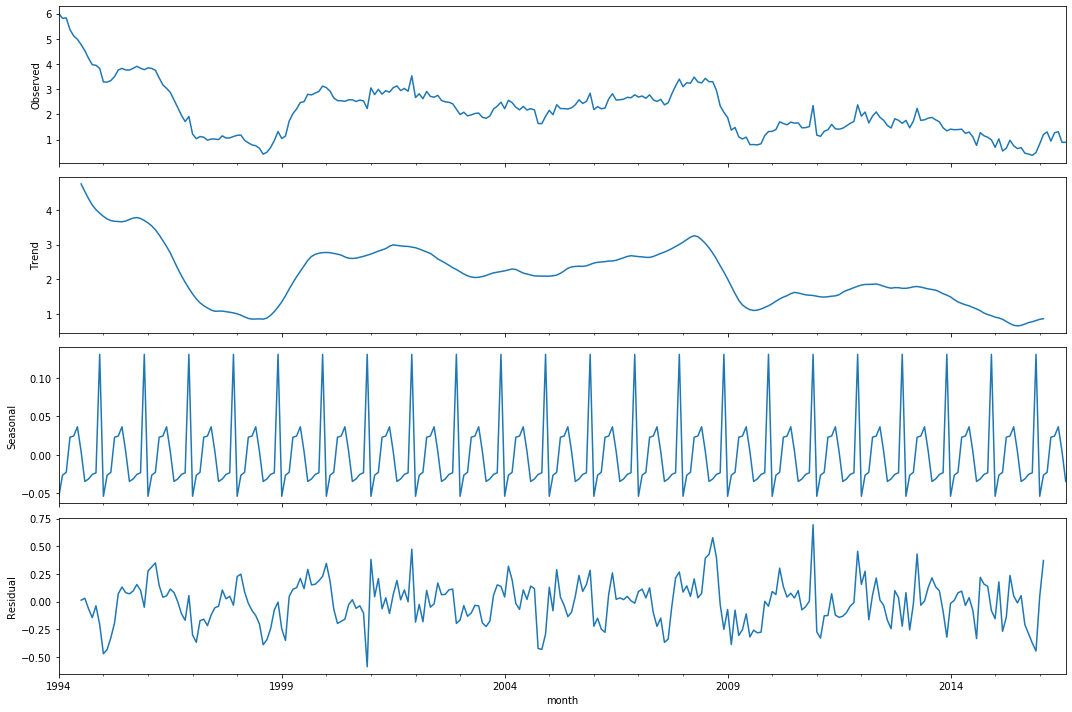

In [12]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries['box_cox_diff'][12:]).plot()
print("")

In [13]:
# Task 3
# Выбор порядка дифференцирования

# На графике видна большая вершина и глубокий провал вначале, имеет смысл продифференцировать данные еще раз
salaries['box_cox_diff_2'] = salaries['box_cox_diff'] - salaries['box_cox_diff'].shift(1)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salaries['box_cox_diff_2'][13:])[1])

Критерий Дики-Фуллера: p=0.000000


Text(0, 0.5, 'Дифферецированные данные')

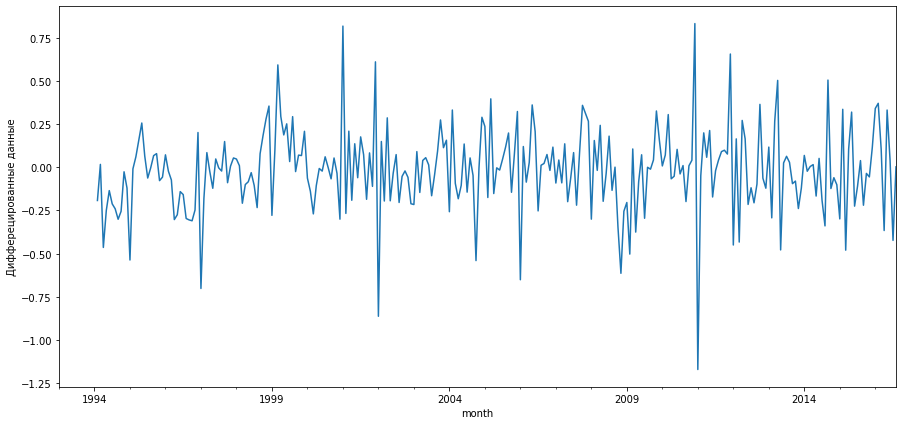

In [14]:
plt.figure(figsize(15,7))
salaries['box_cox_diff_2'].plot()
plt.ylabel(u'Дифферецированные данные')

<Figure size 1080x720 with 0 Axes>

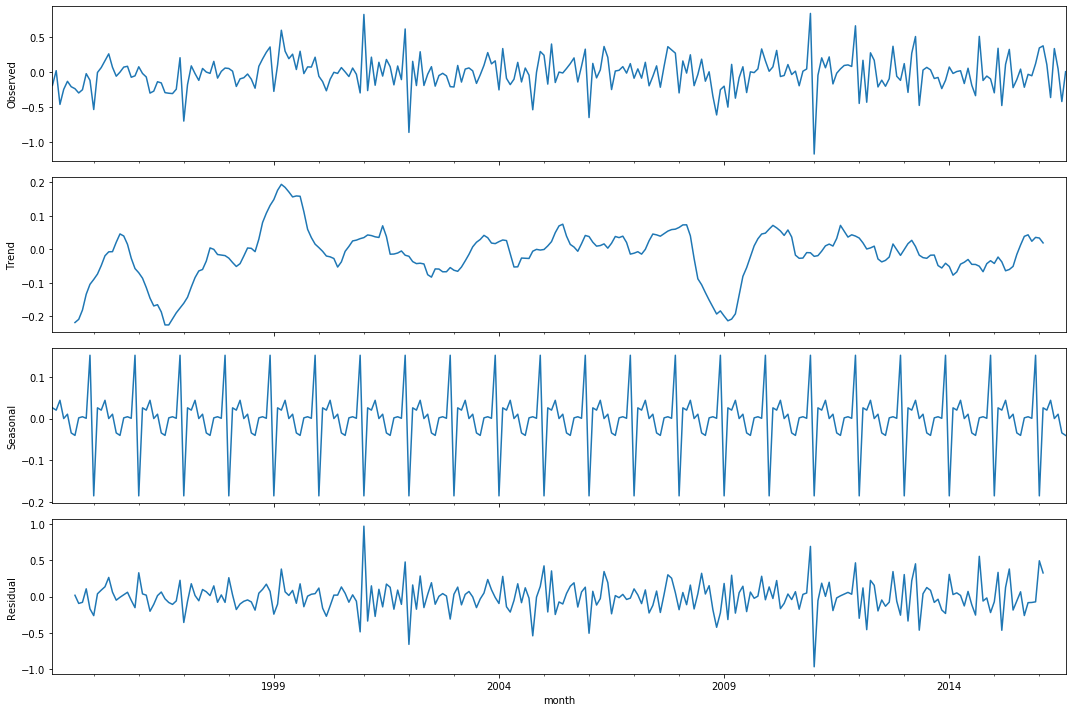

In [15]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salaries['box_cox_diff_2'][13:]).plot()
print("")

In [16]:
salaries

,month,WAG_C_M,box_cox,box_cox_diff,box_cox_diff_2
month,,,,,
1993-01-01,01.01.1993,15.3,3.990393,NaN,NaN
1993-02-01,01.02.1993,19.1,4.458758,NaN,NaN
1993-03-01,01.03.1993,23.6,4.931635,NaN,NaN
1993-04-01,01.04.1993,30.6,5.549430,NaN,NaN
1993-05-01,01.05.1993,37.5,6.063406,NaN,NaN
...,...,...,...,...,...
2016-04-01,01.04.2016,36497.0,56.526742,0.942729,-0.366210
2016-05-01,01.05.2016,37270.0,56.860441,1.275065,0.332336
2016-06-01,01.06.2016,38447.0,57.358885,1.316994,0.041929


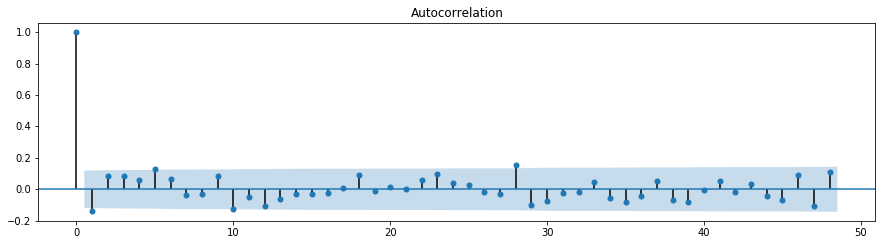

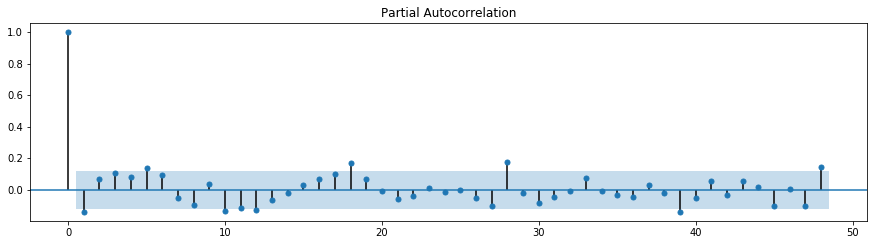

In [17]:
# Task 4
# Выбор начальных приближений

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salaries['box_cox_diff_2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salaries['box_cox_diff_2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [18]:
Q = 1
q = 1

P = 0
p = 1


ps = range(0, p + 1)
qs = range(0, q + 1)
Ps = range(0, P + 1)
Qs = range(0, Q + 1)

d=1
D=1

In [19]:
# Task 5
# Сравнение моделей и выбор победителя

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [20]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(salaries['box_cox'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 3.63 s, sys: 520 ms, total: 4.16 s
Wall time: 764 ms


In [21]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 0, 1)  0.774438
3  (0, 1, 0, 1)  1.581782
7  (1, 1, 0, 1)  2.418753
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


In [22]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            box_cox   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                   2.613
Date:                            Sun, 19 Apr 2020   AIC                              0.774
Time:                                    18:12:58   BIC                             11.581
Sample:                                01-01-1993   HQIC                             5.113
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1451      0.046     -3.125      0.002      -0.236      -0.054
ma.S.L12      -0.1185      0.047   

Критерий Стьюдента: p=0.091684
Критерий Дики-Фуллера: p=0.000003


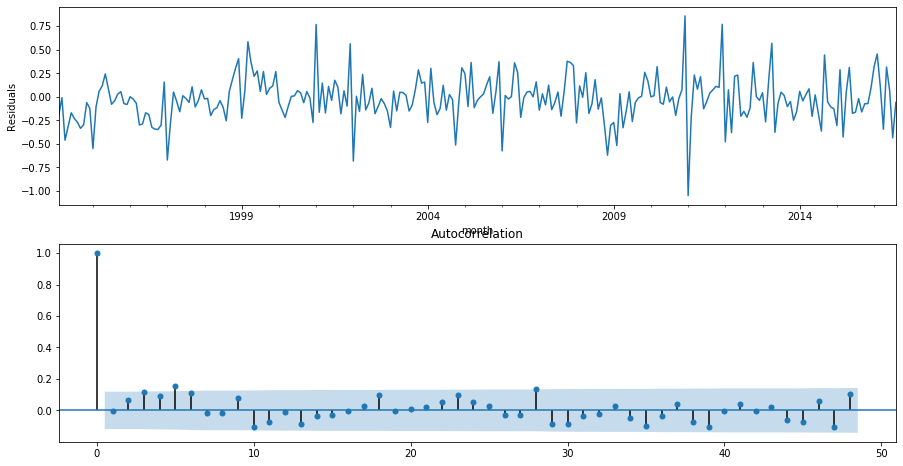

In [23]:
# Task 6
# Анализ остатков

plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [24]:
salaries

,month,WAG_C_M,box_cox,box_cox_diff,box_cox_diff_2
month,,,,,
1993-01-01,01.01.1993,15.3,3.990393,NaN,NaN
1993-02-01,01.02.1993,19.1,4.458758,NaN,NaN
1993-03-01,01.03.1993,23.6,4.931635,NaN,NaN
1993-04-01,01.04.1993,30.6,5.549430,NaN,NaN
1993-05-01,01.05.1993,37.5,6.063406,NaN,NaN
...,...,...,...,...,...
2016-04-01,01.04.2016,36497.0,56.526742,0.942729,-0.366210
2016-05-01,01.05.2016,37270.0,56.860441,1.275065,0.332336
2016-06-01,01.06.2016,38447.0,57.358885,1.316994,0.041929


In [25]:
invboxcox(best_model.fittedvalues, lmbda)

month
1993-01-01        1.000000
1993-02-01       15.300000
1993-03-01       19.100000
1993-04-01       23.600000
1993-05-01       30.600000
                  ...     
2016-04-01    37297.615440
2016-05-01    36537.525679
2016-06-01    38281.751502
2016-07-01    36889.264944
2016-08-01    34228.208707
Length: 284, dtype: float64

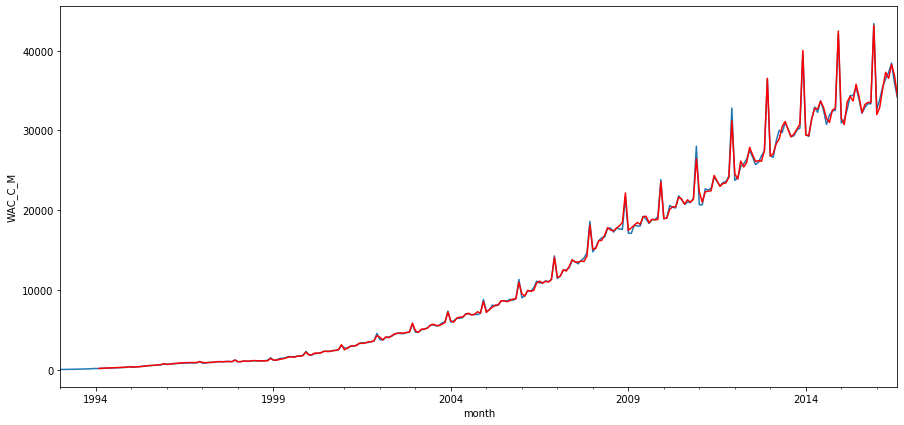

In [26]:
# Кажется, что в остатках не прослеживается структуры, они похожи на шум
# Критерий несмещенности не отвергается, критерий нестационарности отвергается

salaries['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salaries['WAG_C_M'].plot()
salaries['model'][13:].plot(color='r')
plt.ylabel('WAC_C_M')
pylab.show()

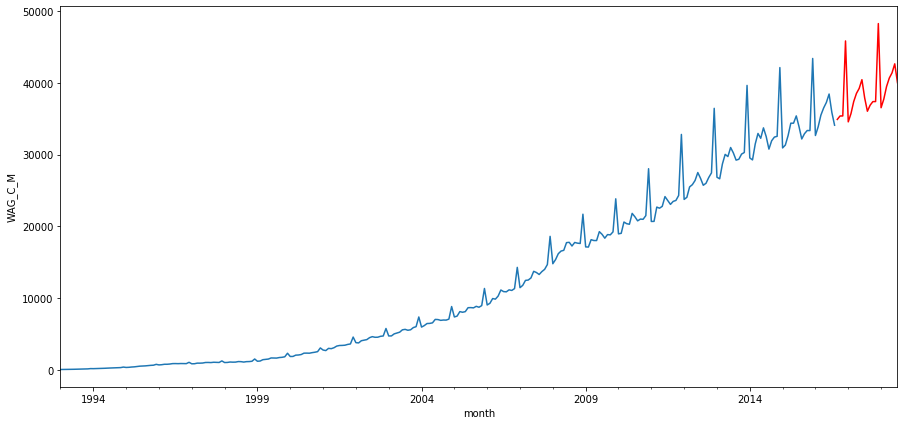

In [27]:
# Task 7
# Прогнозирование с помощью финальной модели

salaries2 = salaries[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salaries2.columns)
salaries2 = pd.concat([salaries2, future])
salaries2['forecast'] = invboxcox(best_model.predict(start=284, end=306), lmbda)

plt.figure(figsize(15,7))
salaries['WAG_C_M'].plot()
salaries2['forecast'].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()